<a href="https://colab.research.google.com/github/cbwid/CV-Learning/blob/main/tensorflow/colab/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Image Classification with TensorFlow Hub

In this colab, you'll try multiple image classification models from TensorFlow Hub and decide which one is best for your use case.

Because TF Hub encourages a [consistent input convention](https://www.tensorflow.org/hub/common_saved_model_apis/images#image_input) for models that operate on images, it's easy to experiment with different architectures to find the one that best fits your needs.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#@title Helper functions for loading image (hidden)

original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

Select an Image Classification Model. After that, some internal variables are set and the labels file is downloaded and prepared for use.

There are some technical differences between the models, like different input size, model size, accuracy, and inference time. Here you can change the model you are using until you find the one most suitable for your use case.

The handle (url) of the model is printed for your convenience. More documentation about each model is available there.

Note: All these models were trained on the ImageNet dataset

In [3]:
#@title Select an Image Classification model

image_size = 224
dynamic_size = False

model_name = "efficientnetv2-s" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/classification/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/classification/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/classification/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/classification/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/classification/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/classification/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/classification/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/classification/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/classification/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/classification/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/classification/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/classification/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/classification/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/classification/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/classification/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/classification/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/classification/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/classification/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/classification/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/classification/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/classification/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/classification/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/classification/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "mobilenet_v2_100_224": 224,
  "mobilenet_v2_130_224": 224,
  "mobilenet_v2_140_224": 224,
  "nasnet_large": 331,
  "nasnet_mobile": 224,
  "pnasnet_large": 331,
  "resnet_v1_50": 224,
  "resnet_v1_101": 224,
  "resnet_v1_152": 224,
  "resnet_v2_50": 224,
  "resnet_v2_101": 224,
  "resnet_v2_152": 224,
  "mobilenet_v3_small_100_224": 224,
  "mobilenet_v3_small_075_224": 224,
  "mobilenet_v3_large_100_224": 224,
  "mobilenet_v3_large_075_224": 224,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")


max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []
i = 0
with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels[1:]]
  i += 1

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
Images will be converted to 384x384
24576/10484 [======================================================================] - 0s 0us/step


You can select one of the images below, or use your own image. Just remember that the input sizes for the models vary and some of them use a dynamic input size (enabling inference on the unscaled image). Given that, the method `load_image` will already rescale the image to the expected format.

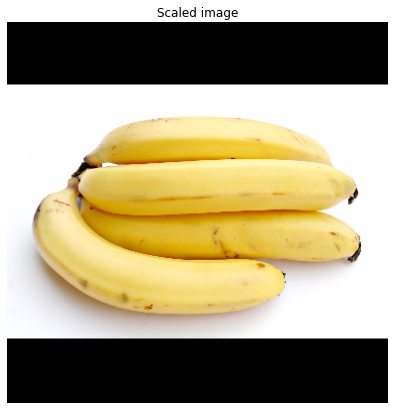

In [8]:
#@title Select an Input Image

image_name = "banana" # @param ['tiger', 'bus', 'car', 'cat', 'dog', 'apple', 'banana', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot']

images_for_test_map = {
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    #by Charles James Sharp, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "bus": "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg",
    #by Martin49 from London, England, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "car": "https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg",
    #by EurovisionNim, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    #by Alvesgaspar, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    #by Craig Pemberton, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    #by Abhijit Tembhekar from Mumbai, India, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "banana": "https://upload.wikimedia.org/wikipedia/commons/1/1c/Bananas_white_background.jpg",
    #by fir0002  flagstaffotos [at] gmail.com		Canon 20D + Tamron 28-75mm f/2.8, GFDL 1.2 <http://www.gnu.org/licenses/old-licenses/fdl-1.2.html>, via Wikimedia Commons
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    #by Claudio Giovenzana, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    #by Christian Mehlführer, User:Chmehl, CC BY 3.0 <https://creativecommons.org/licenses/by/3.0>, via Wikimedia Commons
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    #by "Photo: © Copyright Steinway & Sons", CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    #by Merdal, CC BY-SA 3.0 <http://creativecommons.org/licenses/by-sa/3.0/>, via Wikimedia Commons
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
    #by Mendhak, CC BY-SA 2.0 <https://creativecommons.org/licenses/by-sa/2.0>, via Wikimedia Commons
}

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
show_image(image, 'Scaled image')

Now that the model was chosen, loading it with TensorFlow Hub is simple.

This also calls the model with a random input as a "warmup" run. Subsequent calls are often much faster, and you can compare this with the latency below.

*Note:* models that use a dynamic size might need a fresh "warmup" run for each image size.

In [6]:
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

CPU times: user 3.03 s, sys: 730 ms, total: 3.76 s
Wall time: 30 s


Everything is ready for inference. Here you can see the top 5 results from the model for the selected image.

CPU times: user 68.1 ms, sys: 0 ns, total: 68.1 ms
Wall time: 69.5 ms
(1)  954 - banana: 0.9017890095710754
(2)  953 - pineapple: 0.002095611533150077
(3)  950 - orange: 0.001644916133955121
(4)  582 - grocery store: 0.0008510537445545197
(5)  940 - spaghetti squash: 0.0008459570817649364


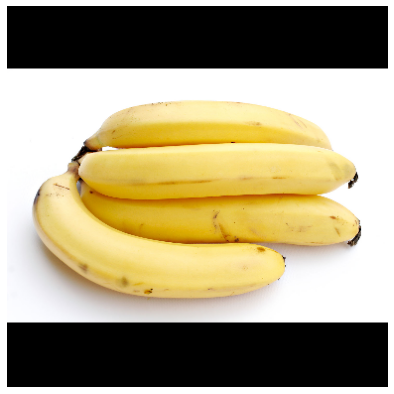

In [9]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(image, '')

## Learn More

If you want to learn more and try how to do Transfer Learning with these models you can try this tutorial: [Transfer Learning for Image classification](https://www.tensorflow.org/hub/tutorials/tf2_image_retraining) 

If you want to check on more image models you can check them out on [tfhub.dev](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-classification-logits,image-classifier,image-feature-vector,image-generator,image-object-detection,image-others,image-pose-detection,image-segmentation,image-style-transfer,image-super-resolution,image-rnn-agent)